# Independent Modeling Project - Christopher Zhen

In [3]:
# Necessary to find the nupack wrappers
import sys
sys.path.append('/home/jovyan/work')

# Nupack packages
import nupack.utils as npk

# Utilities
import numpy as np
from scipy.integrate import odeint
import random
import numba
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

In this project, I implemented a variation of the Floyd-Warshall DP algorithm traditionally used to calculate path lengths in connected graphs to try and count the number of possible secondary structures (loops) in a strand of DNA or RNA efficiently in O(N$^4$) time. After this, I try to replicate theoretical results for kinetic modeling of folding using Gillespie's algorithm.

In [5]:
def count(rna):
    """
    Count the number of secondary structures present in a strand of DNA or RNA without considering pseudoknots
    
    Parameters
    ----------
    rna: string object, strand of DNA/RNA (all CAPS)
    
    Returns
    -------
    output: int object, number of secondary structures in a strand of DNA/RNA
    
    Notes
    -----
    The code doesn't consider pseudoknot structures, but does take into account wobble base pairing
    """
    
    # Used to determine allowed pairing
    comp = 'ACGUBT'
    n = len(rna)
    
    # Initialize arrays used for dp algorithm
    Q = np.zeros([n+1,n+1])
    Qb = np.zeros([n+1,n+1])
    Qm = np.zeros([n+1,n+1])
    Qc = np.zeros([n+1,n+1])

    # Set diagonals to 1
    for t in range(n+1):
        Q[t,t-1] = 1
        
    # Dynamically count the number of loops between l and i
    for l in range(1,n+1):
        for i in range(1,n-l+2):
            j = i+l-1
            Q[i,j] = 1
            
            if j > i+3:
                
                # Allows for A-T, A-U, G-C, G-U, and G-T pairing
                if comp.index(rna[i-1]) + comp.index(rna[j-1]) == 3 or comp.index(rna[i-1]) \
                    + comp.index(rna[j-1]) == 5 or comp.index(rna[i-1]) + comp.index(rna[j-1]) == 7:
                    Qb[i,j] = 1
                    Qc[i,j] = 1
                    
            # Account for inner loops
            for d in range(i+1, j-4):
                for e in range(d+4, j):
                    Qb[i,j] += Qb[d,e]*Qc[d,e]
                    Qb[i,j] += Qm[i+1,d-1]*Qb[d,e]*Qc[d,e]
            
            # Count loops outside main loop
            for f in range(i, j-3):
                for g in range(f+4, j+1):
                    Q[i,j] += Q[i,f-1]*Qb[f,g]*Qc[f,g]
                    Qm[i,j] += Qb[f,g]*Qc[f,g]
                    Qm[i,j] += Qm[i,f-1]*Qb[f,g]*Qc[f,g]    
    
    return Q[1,n]

This code implements the algorithm, allowing for wobble base pairs (G-U, G-T) for bases at least 4 apart. Running several test cases we get the following results and verify that the code works:

In [6]:
print(count('GGACUACGACU'))
print(count('GCGCTATACGCGATAT'))
print(count('UCGCUCGCUAUGCGA'))
print(count('AUUCAUAUGGCGUGCCCCGCUGUCUCAGACAGCCC'))

28.0
242.0
265.0
5341469.0


Now we'll write some code to find the average number of secondary structures in a sequence of 100 bps just for fun:

In [21]:
counter = 0
nuc = ['A', 'C', 'U', 'G']
for i in range(10):
    seq = np.random.choice(nuc, size=101)
    counter += count(seq)
print(counter/10)

8.71701402676e+23


Since there are over $4.2*10^{23}$ structures for a 100 base pair sequence (smallest value from running this code several times) and each calculation takes $1*10^{-9}$ seconds, it'll take over $4.2*10^{14}$ seconds to calculate the partition function of the strand. This is equivalent to over 13 million years!

Now, we'll look at the folding dynamics for these structures. The following set of ODEs describes the behavior of the system (non-stochastically):

$$\begin{align}
\frac{dc_a}{dt} & = k_{au}c_u - k_{ua}c_a \\
\frac{dc_u}{dt} & = k_{ua}c_a + k_{ub}c_b -(k_{au}+k_{bu})c_u \\
\frac{dc_b}{dt} & = k_{bu}c_u - k_{ub}c_b
\end{align}$$

We need to calculate the energies of the folded states with the Nupack energy method for an example sequence:

In [16]:
Ea = npk.energy('GCCAUGGCCAUGAAACAUGGC','((((((.........))))))')
Eb = npk.energy('GCCAUGGCCAUGAAACAUGGC','......((((((...))))))')
Eu = npk.energy('GCCAUGGCCAUGAAACAUGGC','.....................')
print(Eu,Ea,Eb)
print(Eu/0.61597,Ea/0.61597,Eb/0.61597) #0.61597 is kT at 37 C

0.0 -7.9 -6.7
0.0 -12.825299933438316 -10.877153108105913


So we now have our G/kT values and we can calculate our k values based on the following relationships:

$$\begin{align}
k_{ua} & = k_{au} e^{-(G_u-G_a)/kT} \\
k_{ub} & = k_{bu} e^{-(G_u-G_b)/kT} \\
k_{au} & = 1 \\
k_{bu} & = 10
\end{align}$$

From these relationships we find the following values for $k_{ua}$ and $k_{ub}$:

$$\begin{align}
k_{ua} & = 2.68*10^{-6} \\
k_{ub} & = 1.89*10^{-4}
\end{align}$$

Plugging these back into our system of ODEs, we get the following set of ODEs and initial conditions:

$$\begin{align}
\frac{dc_a}{dt} & = c_u - 2.68*10^{-6}c_a \\
\frac{dc_u}{dt} & = 2.68*10^{-6}c_a + 1.89*10^{-4}c_b -11c_u \\
\frac{dc_b}{dt} & = 10c_u - 1.89*10^{-4}c_b
\end{align}$$

We can also plot the results as a function of time:

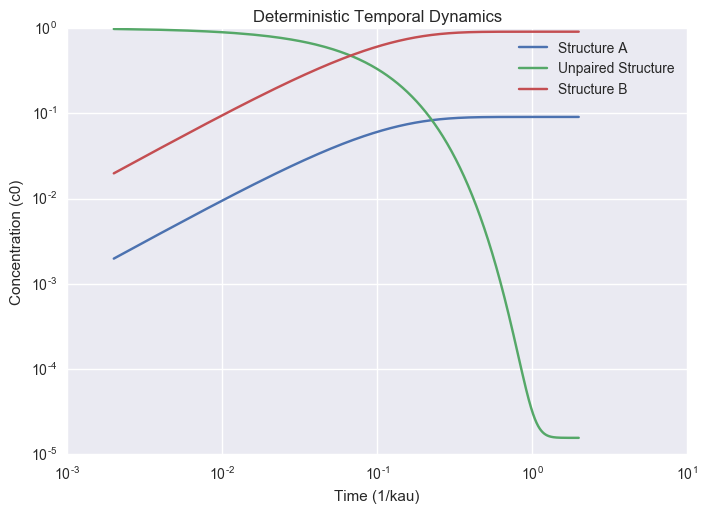

In [7]:
k = np.array([2.68*10**(-6),0,1,10,0,1.89*10**(-4)])

def f(y, t):
    cA0 = y[0]
    cU0 = y[1]
    cB0 = y[2]
    f0 = k[2]*cU0-k[0]*cA0
    f1 = k[0]*cA0+k[5]*cB0-(k[2]+k[3])*cU0
    f2 = k[3]*cU0-k[5]*cB0
    return [f0,f1,f2]

y0 = [0,1,0]
t = np.linspace(0, 2, 1000)

soln = odeint(f, y0, t)
cA = soln[:, 0]
cU = soln[:, 1]
cB = soln[:, 2]

plt.figure()
plt.loglog(t, cA, label='Structure A')
plt.loglog(t, cU, label='Unpaired Structure')
plt.loglog(t, cB, label='Structure B')
plt.xlabel('Time (1/kau)')
plt.ylabel('Concentration (c0)')
plt.title('Deterministic Temporal Dynamics')
plt.legend(loc=0)

Now, in order to improve our calculations, we need to take into account the stochastic nature of these folding interactions. To do this, we'll write a function to implement Gillespie's algorithm which is a Monte Carlo method for mapping events based on the probabilities and arrival times for those events. In our code, we'll assume that binding is a memory-less Poisson process, so in order to model arrival times, we'll draw from an exponential distribution:

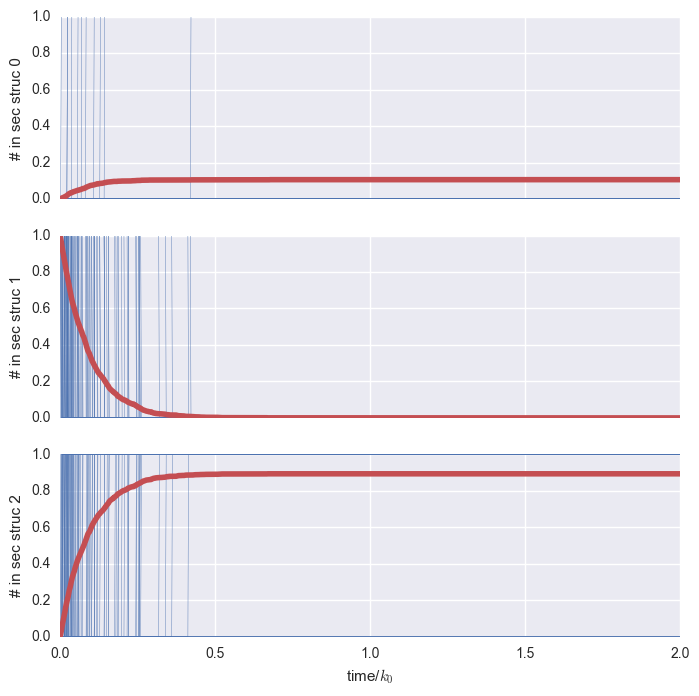

In [18]:
# Array representing state changes
update = np.array([[-1, 1, 0],
                   [-1, 0, 1],
                   [1, -1, 0],
                   [0, -1, 1],
                   [1, 0, -1],
                   [0, 1, -1]])

@numba.jit(nopython = True)
def propensity(k, population):
    """
    Returns an array of propensities for folding of a short hairpin.
    """
    reactant_population = np.empty(2*len(population))
    reactant_population[::2] = population
    reactant_population[1::2] = population

    return k * reactant_population

@numba.jit(nopython=True)
def sample_discrete(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

def gillespie_draw(params, propensity_func, population):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    params : arbitrary
        The set of parameters to be passed to propensity_func.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    population : array_like, shape (num_chemical_species)
        Populations of all chemical species.
        
    Returns
    -------
    rxn : int
        Index of the reaction that was drawn.
    time : float
        The amount of time it took for the reaction to happen.
    """
    # Compute propensities
    props = propensity_func(params, population)
    
    # Sum of propensities
    props_sum = np.sum(props)
    
    # Compute time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time

def gillespie_ssa(params, propensity_func, update, population_0, 
                  time_points):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    params : arbitrary
        The set of parameters to be passed to propensity_func.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    while i < len(time_points):
        while t < time_points[i_time]:
            
            # Draw the event and time step
            event, dt = gillespie_draw(params, propensity_func, population)
                
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
                
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                           
    return pop_out

# Specify parameters for calculation
time_points = np.linspace(0, 2, 1000)
population_0 = np.array([0, 1, 0], dtype=int) # Unpaired
n_simulations = 2000

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
pops = np.empty((n_simulations, len(time_points), len(population_0)))

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa(k, propensity, update, population_0, time_points)
    
# Plot trajectories
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

for i, ax in enumerate(axes):
    # Plot trajectories (only 10% of them, since there are many)
    for j in range(0, n_simulations, 20):
        ax.plot(time_points, pops[j,:,i], '-', lw=0.3, alpha=1, 
                color=sns.color_palette()[0])

    # Plot mean
    ax.plot(time_points, pops[:,:,i].mean(axis=0), '-', lw=4, 
            color=sns.color_palette()[2])
    
    axes[i].set_ylabel('# in sec struc ' + str(i))

# Label axes
axes[-1].set_xlabel('time/$k_0$');

We can see that we get similar results as before as our theoretical results, however the advantage of using this sampling algorithm is in more complicated situations when we don't necessarily have a model for how the system behaves and we can use  a Monte Carlo method to effectively model it.